In [44]:
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
map_base_dir = 'annotations'
map_img_dir = 'splited'

In [45]:
json_path = os.path.join(map_base_dir, 'annotation.json')
with open(json_path, 'r') as f:
    annot_data = json.load(f)

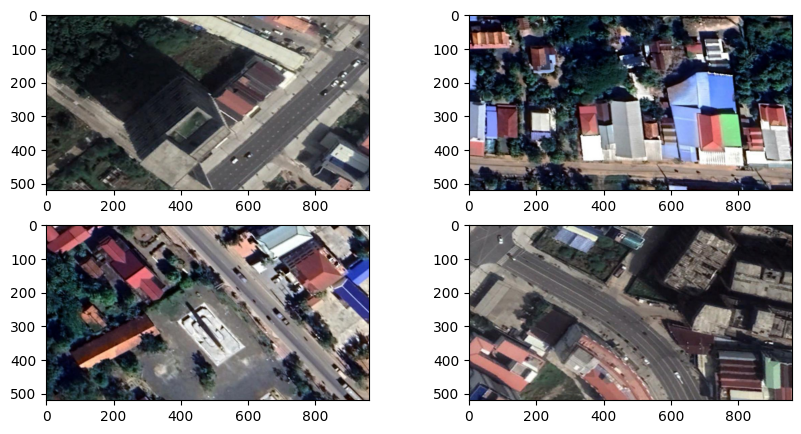

In [46]:
image_df = pd.DataFrame(annot_data['images'])
image_df.sample(3)
fig, m_axs = plt.subplots(2, 2, figsize = (10, 5))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [47]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(3)

,id,datatorch_id,image_id,category_id,segmentation,area,bbox,iscrowd
6451,6452,6571bf70-6e98-4be7-a1b5-e079ef852fd8,592,1,"[[316.9, 401.7, 346.8, 403.1, 356.9, 460.9, 33...",4613.00,"[281.5, 401.7, 75.39999999999998, 73.600000000...",0
10951,10952,aaab7f23-64b9-4b4f-bada-c8c427b2a0b4,374,1,"[[943.5, 371.2, 945.2, 371.2, 951.7, 392.9, 95...",1278.26,"[910.6, 371.2, 49.299999999999955, 45.5]",0
6732,6733,69be4bff-a4ea-4b92-bc2b-719d02122dd1,18,1,"[[556.4, 149.7, 595, 141.9, 611.4, 195.6, 578....",2054.35,"[556.4, 141.9, 55, 60.599999999999994]",0


In [48]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(2)

800 + 16515 -> 16515


,id_x,datatorch_id_x,image_id,category_id,segmentation,area,bbox,iscrowd,id_y,datatorch_id_y,storage_id,path,width,height,file_name,metadata,date_captured
12977,12978,ca0e1d4e-793d-4b42-b0dc-7dfc5da6154e,344,1,"[[771.9, 163.9, 819.1, 181.6, 816.8, 193.1, 80...",1486.50,"[757.9, 163.9, 61.200000000000045, 41.79999999...",0,344,2fda4877-b6d5-469a-91f0-bdc50def30bf,905221b1-4438-4814-bdb3-6d5aaffda4f0,ps_img3.jpg33.jpg,960,520,ps_img3.jpg33.jpg,{},2022-09-19T03:47:35.737Z
15343,15344,ee2b975c-2b0a-403e-80fb-a9943e429abe,416,1,"[[245.4, 113, 296.8, 131.8, 304.5, 144.3, 316....",4161.62,"[219.8, 113, 96.30000000000001, 72.6]",0,416,e2f64ddc-92da-43be-9ed2-414dec0d0711,905221b1-4438-4814-bdb3-6d5aaffda4f0,ps_img6.jpg30.jpg,960,520,ps_img6.jpg30.jpg,{},2022-09-19T03:47:02.048Z


In [49]:
def create_boxes(in_rows):
    #TODO: this seems to get a few of the boxes wrong so we stick to segmentation polygons instead
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox from the coco standard
        (start_y, start_x, wid_y, wid_x) = in_row['bbox']
        
        box_list += [Rectangle((start_x, start_y), 
                         wid_y , wid_x
                         )]
    return box_list

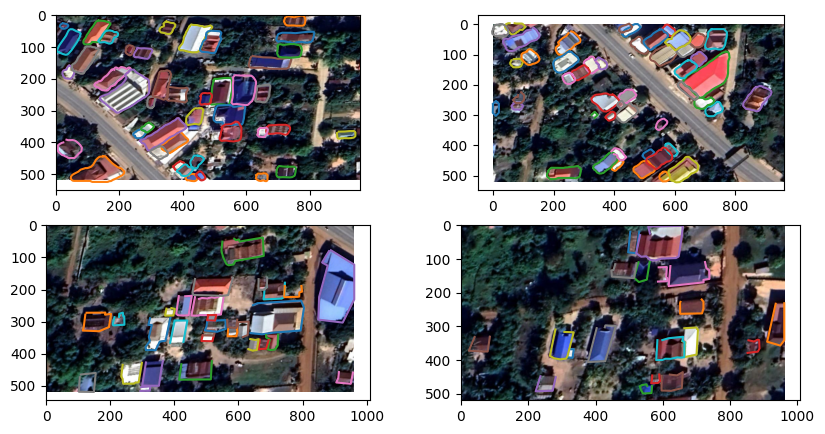

In [50]:
fig, m_axs = plt.subplots(2, 2, figsize = (10, 5))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    #c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

# Convert Polygons to Segmentations
We can use the `Path` function of matplotlib on a `np.meshgrid` of $x,y$ values in order to convert the polygon into a binary image to use as the segmentation.

In [51]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

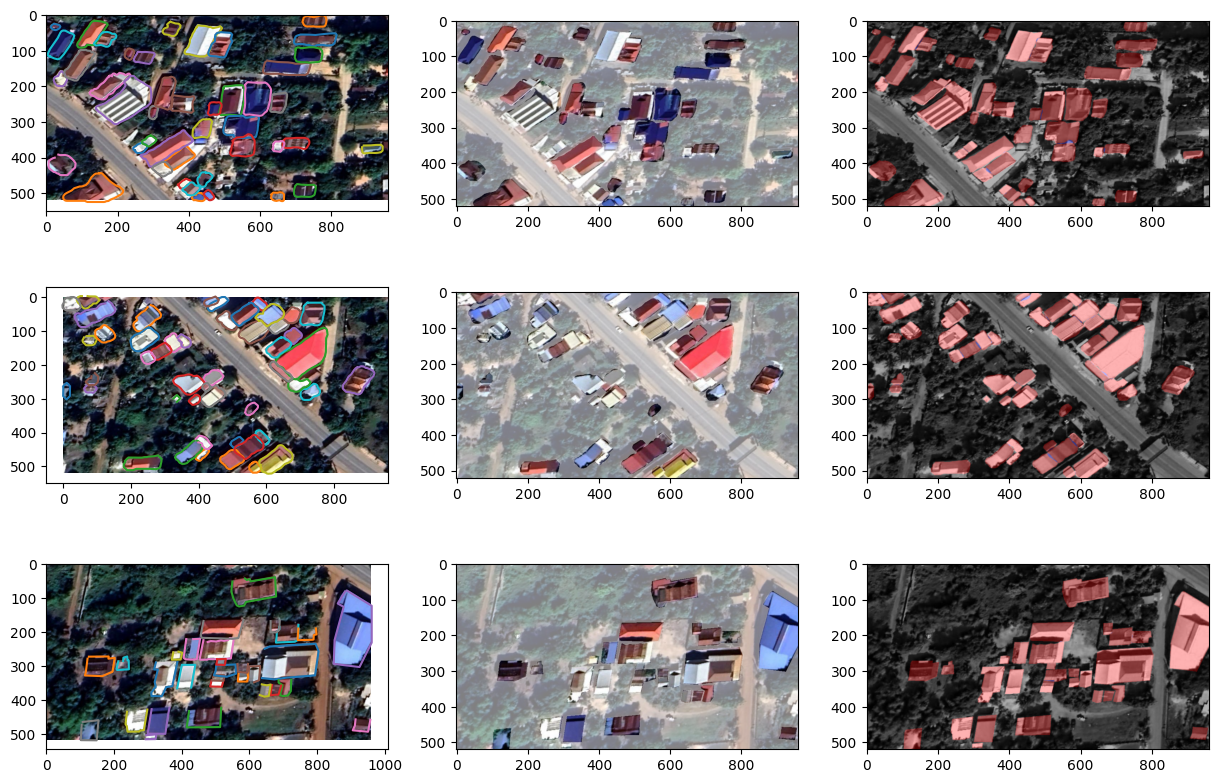

In [52]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 10))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data, 
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)
    
    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))

In [53]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

12094 training boxes
4421 validation boxes


In [54]:
def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img)>=batch_size:
                yield (np.stack(out_img, 0)/255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []
valid_gen = batch_img_gen(valid_df, 8)

In [55]:
import skimage.util
t_x, t_y = next(valid_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')

/tmp/ipykernel_31814/3766723584.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):
/tmp/ipykernel_31814/3332028876.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))


ValueError: setting an array element with a sequence.

In [ ]:
BLOCK_COUNT = 1
EDGE_CROP = 16
BASE_DEPTH = 16
SPATIAL_DROPOUT = 0.25
GAUSSIAN_NOISE = 0.1
BATCH_SIZE = 24

In [ ]:
from keras import models, layers
def conv_bn(x, filt, dl_rate=(1,1), preblock = False):
    y = layers.Convolution2D(filt, (3, 3), 
                             activation='linear', 
                             padding='same', 
                             dilation_rate=dl_rate,
                            use_bias=False)(x)
    if preblock: return y
    y = layers.BatchNormalization()(y)
    return layers.Activation('elu')(y)

in_layer = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c = conv_bn(pp_in_layer, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH)

skip_layers = [pp_in_layer]
for j in range(BLOCK_COUNT):
    depth_steps = int(np.log2(t_x.shape[1])-2)
    d = layers.concatenate(skip_layers+[conv_bn(c, BASE_DEPTH*2**j, (2**i, 2**i), preblock=True) 
                                        for i in range(depth_steps)])
    d = layers.SpatialDropout2D(SPATIAL_DROPOUT)(d)
    d = layers.BatchNormalization()(d)
    d = layers.Activation('elu')(d)
    # bottleneck
    d = conv_bn(d, BASE_DEPTH*2**(j+1))
    skip_layers += [c]
    c = d
d = layers.Convolution2D(1, (1, 1), activation='sigmoid', padding='same')(d)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
seg_model = models.Model(inputs = [in_layer],
                    outputs = [d])
seg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 520, 960, 3  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise_1 (GaussianNois  (None, 520, 960, 3)  0          ['RGB_Input[0][0]']              
 e)                                                                                               
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 520, 960, 3)  12         ['gaussian_noise_1[0][0]']       
 rmalization)                                                                               

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.05*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
valid_gen = batch_img_gen(valid_df, BATCH_SIZE)
loss_history = [seg_model.fit(batch_img_gen(train_df, BATCH_SIZE), 
                             steps_per_epoch=min(train_ids.shape[0]//BATCH_SIZE, 100),
                             epochs=2, 
                             validation_data = valid_gen,
                             validation_steps = min(train_ids.shape[0]//BATCH_SIZE, 50),
                             callbacks=callbacks_list,
                            workers=2)]

/tmp/ipykernel_45972/3766723584.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):
/tmp/ipykernel_45972/3332028876.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))


ValueError: setting an array element with a sequence.

In [ ]:
seg_model.load_weights(weight_path)
seg_model.save('full_best_model.h5')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'seg_model_weights.best.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]
    
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)

/tmp/ipykernel_45972/3766723584.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):
/tmp/ipykernel_45972/3332028876.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))


ValueError: setting an array element with a sequence.